In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

import ktrain
from ktrain import text
from sklearn.utils import class_weight

## Read Data

In [2]:
df = pd.read_json('yelp_academic_dataset_review.json', lines=True)
review_df = df.sample(n=5000)

## Exploratory Data Analysis

In [3]:
# Checking missing values
review_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

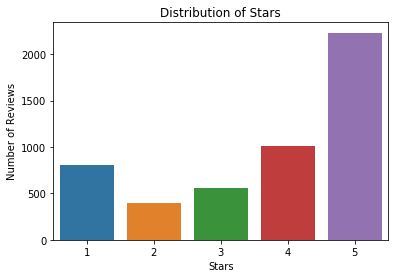

In [4]:
# Distribution of Stars(Reviews) 
plt.figure(figsize=(6,4))
sns.countplot(review_df.stars)
plt.title('Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.show()

## Text Processing

In [5]:
contractions_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "cannot", 
                    "can't've": "cannot have", 
                    "'cause": "because", 
                    "could've": "could have", 
                    "couldn't": "could not", 
                    "couldn't've": "could not have",
                    "didn't": "did not", 
                    "doesn't": "does not", 
                    "don't": "do not", 
                    "hadn't": "had not",  
                    "hadn't've": "had not have", 
                    "hasn't": "has not", 
                    "haven't": "have not", 
                    "he'd": "he would", 
                    "he'd've": "he would have", 
                    "he'll": "he will", 
                    "he'll've": "he will have", 
                    "he's": "he is", 
                    "how'd": "how did", 
                    "how'd'y": "how do you", 
                    "how'll": "how will", 
                    "how's": "how is", 
                    "I'd": "I would", 
                    "I'd've": "I would have", 
                    "I'll": "I will", 
                    "I'll've": "I will have",
                    "I'm": "I am", 
                    "I've": "I have", 
                    "i'd": "i would", 
                    "i'd've": "i would have", 
                    "i'll": "i will", 
                    "i'll've": "i will have",
                    "i'm": "i am", 
                    "i've": "i have", 
                    "isn't": "is not", 
                    "it'd": "it would", 
                    "it'd've": "it would have", 
                    "it'll": "it will", 
                    "it'll've": "it will have",
                    "it's": "it is", 
                    "let's": "let us", 
                    "ma'am": "madam", 
                    "mayn't": "may not", 
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have", 
                    "must've": "must have", 
                    "mustn't": "must not", 
                    "mustn't've": "must not have", 
                    "needn't": "need not", 
                    "needn't've": "need not have",
                    "o'clock": "of the clock", 
                    "oughtn't": "ought not", 
                    "oughtn't've": "ought not have", 
                    "shan't": "shall not",
                    "sha'n't": "shall not", 
                    "shan't've": "shall not have", 
                    "she'd": "she would", 
                    "she'd've": "she would have", 
                    "she'll": "she will", 
                    "she'll've": "she will have", 
                    "she's": "she is", 
                    "should've": "should have", 
                    "shouldn't": "should not", 
                    "shouldn't've": "should not have", 
                    "so've": "so have",
                    "so's": "so as", 
                    "this's": "this is",
                    "that'd": "that would", 
                    "that'd've": "that would have",
                    "that's": "that is", 
                    "there'd": "there would", 
                    "there'd've": "there would have",
                    "there's": "there is", 
                    "here's": "here is",
                    "they'd": "they would", 
                    "they'd've": "they would have", 
                    "they'll": "they will", 
                    "they'll've": "they will have", 
                    "they're": "they are", 
                    "they've": "they have",
                    "to've": "to have", 
                    "wasn't": "was not", 
                    "we'd": "we would", 
                    "we'd've": "we would have", 
                    "we'll": "we will", 
                    "we'll've": "we will have", 
                    "we're": "we are", 
                    "we've": "we have", 
                    "weren't": "were not",
                    "what'll": "what will", 
                    "what'll've": "what will have", 
                    "what're": "what are", 
                    "what's": "what is", 
                    "what've": "what have", 
                    "when's": "when is", 
                    "when've": "when have", 
                    "where'd": "where did", 
                    "where's": "where is", 
                    "where've": "where have", 
                    "who'll": "who will", 
                    "who'll've": "who will have", 
                    "who's": "who is", 
                    "who've": "who have", 
                    "why's": "why is", 
                    "why've": "why have", 
                    "will've": "will have", 
                    "won't": "will not",
                    "won't've": "will not have", 
                    "would've": "would have", 
                    "wouldn't": "would not", 
                    "wouldn't've": "would not have", 
                    "y'all": "you all", 
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would", 
                    "you'd've": "you would have", 
                    "you'll": "you will", 
                    "you'll've": "you will have", 
                    "you're": "you are", 
                    "you've": "you have" }

In [6]:
def expand_contractions(s, contractions_dict=contractions_dict):
    for key in contractions_dict:
        value = contractions_dict[key]
        s = s.replace(key, value)   
    return s

In [7]:
def text_cleaner(s):
        s = str(s)
        s = s.lower()
        s = expand_contractions(s)
        s = re.sub("\n"," ",s)
        s = re.sub("\[.*\]"," ",s)
        s = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}"," ",s)
        s = re.sub(r"\?"," ",s)
        s = re.sub(r'[^\w\s]','',s)
        s = re.sub("\d+","",s)
        s = re.sub(r'(\w)\1{2,}',r'\1\1',s) 
        s = re.sub(r'(\W)\1+',r'\1',s) 
        s = re.sub(r"http\S+","",s)
        s = re.sub("@[^\s]*","",s)
        s = re.sub("#[^\s]*","",s)
        s = re.sub('[0-9]*[+-:]*[0-9]+','',s)
        s = re.sub("'s","",s) 
        
        words = word_tokenize(s)
        lemmatizer = WordNetLemmatizer()
        words_lemma = []
        for word, tag in pos_tag(words):
            if tag.startswith("NN"):
                words_lemma.append(lemmatizer.lemmatize(word, pos='n'))
            elif tag.startswith('VB'):
                words_lemma.append(lemmatizer.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):
                words_lemma.append(lemmatizer.lemmatize(word, pos='a'))
            elif tag.startswith('R'):
                words_lemma.append(lemmatizer.lemmatize(word, pos='r'))    
            else:
                words_lemma.append(word)

        return (" ".join(words_lemma))

        return s

In [8]:
review_df['clean_text'] = review_df.text.map(lambda x: text_cleaner(x))
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text
1943839,es0a4sXwm4TsboLAs4Gsdg,ZVIKw2x0EZqCyQF7mGt1mA,-sAr-LA9TsIdl37UjwBlvg,1,4,0,0,"Dump. Place smelled like smoke, the A/C didn't...",2015-10-14 04:37:06,dump place smell like smoke the ac do not work...
6785961,jJbg_d5NrhxJNEyldFfqog,5A_sSWQHxmYVNCmhVLDTag,L2c-qKZWumCmOCR-dqBLrg,4,0,0,0,Been here once - its located in Downtown Champ...,2018-03-20 03:12:57,be here once its locate in downtown champaign ...
3928982,OpF6-RXhpoZ5W9IFRCWdoQ,maEpH67QwQDr8WbV-OeQfA,d4P7boUqiA2pR59jOlzYLA,3,0,0,0,Plenty of food options here. If you're not hea...,2019-03-11 12:06:58,plenty of food option here if you be not head ...
7976771,IB-K_EZYRp38idzxbqvT_Q,QJTC5x9yHycwvZwmYdR4IQ,ZGgUJmpRbh2VXftRhQmUSA,5,2,0,1,Been coming here ever since I moved into the n...,2018-03-12 10:35:01,be come here ever since i move into the neighb...
1704036,HNV8Zo7hTvtsg1DdSORfWQ,698T9yypM-lneS0YBZHMzg,bRyi5lULMcJoexsg-v498w,4,3,3,3,This PostNet is a local favorite in my communi...,2017-08-09 14:35:48,this postnet be a local favorite in my communi...


In [9]:
def generate_sentiment(stars):
    stars = int(stars)
    if stars <= 2:
        return 0
    elif stars == 3:
        return 1
    else: 
        return 2

In [10]:
review_df['sentiment'] = review_df.stars.apply(generate_sentiment)
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,sentiment
1943839,es0a4sXwm4TsboLAs4Gsdg,ZVIKw2x0EZqCyQF7mGt1mA,-sAr-LA9TsIdl37UjwBlvg,1,4,0,0,"Dump. Place smelled like smoke, the A/C didn't...",2015-10-14 04:37:06,dump place smell like smoke the ac do not work...,0
6785961,jJbg_d5NrhxJNEyldFfqog,5A_sSWQHxmYVNCmhVLDTag,L2c-qKZWumCmOCR-dqBLrg,4,0,0,0,Been here once - its located in Downtown Champ...,2018-03-20 03:12:57,be here once its locate in downtown champaign ...,2
3928982,OpF6-RXhpoZ5W9IFRCWdoQ,maEpH67QwQDr8WbV-OeQfA,d4P7boUqiA2pR59jOlzYLA,3,0,0,0,Plenty of food options here. If you're not hea...,2019-03-11 12:06:58,plenty of food option here if you be not head ...,1
7976771,IB-K_EZYRp38idzxbqvT_Q,QJTC5x9yHycwvZwmYdR4IQ,ZGgUJmpRbh2VXftRhQmUSA,5,2,0,1,Been coming here ever since I moved into the n...,2018-03-12 10:35:01,be come here ever since i move into the neighb...,2
1704036,HNV8Zo7hTvtsg1DdSORfWQ,698T9yypM-lneS0YBZHMzg,bRyi5lULMcJoexsg-v498w,4,3,3,3,This PostNet is a local favorite in my communi...,2017-08-09 14:35:48,this postnet be a local favorite in my communi...,2


In [11]:
# Picking the only the clean text and target columns
final_df = review_df[['clean_text','sentiment']]
final_df.head()

,clean_text,sentiment
1943839,dump place smell like smoke the ac do not work...,0
6785961,be here once its locate in downtown champaign ...,2
3928982,plenty of food option here if you be not head ...,1
7976771,be come here ever since i move into the neighb...,2
1704036,this postnet be a local favorite in my communi...,2


Max length: 990


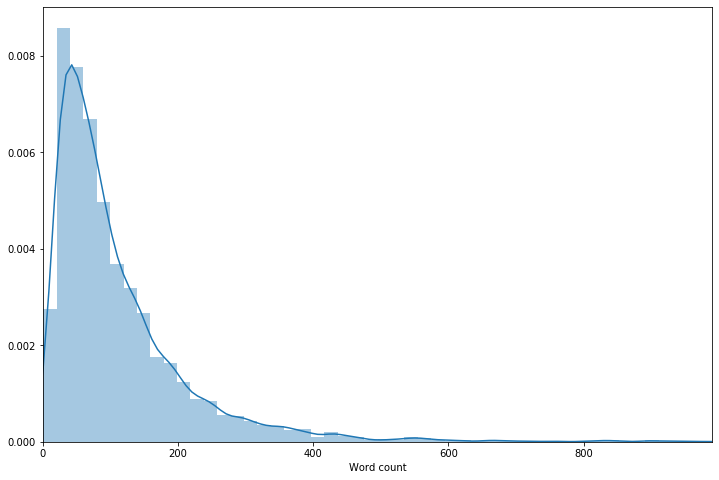

In [12]:
txtlength_df = pd.DataFrame({'txt_length': final_df.clean_text.apply(lambda x: len(x.split()))})
max_length = max(txtlength_df.txt_length)
print('Max length: ' + str(max_length))
plt.figure(figsize=(12,8))
sns.distplot(txtlength_df)
plt.xlim([0, max_length]);
plt.xlabel('Word count')
plt.show()

## Load and Preprocess the Data

In [13]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=final_df,
                                                                   text_column='clean_text',
                                                                   label_columns='sentiment',
                                                                   maxlen=512,
                                                                   val_pct=0.2,
                                                                   preprocess_mode='bert')

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


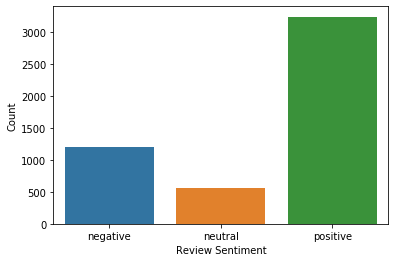

In [14]:
# Checking class imbalance
class_names = ['negative', 'neutral', 'positive']

plt.figure(figsize=(6,4))
ax = sns.countplot(final_df.sentiment)
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
ax.set_xticklabels(class_names)
plt.show()

In [15]:
# Get class weights to give higher weight to minority class and lower weight to majority class.
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(np.argmax(y_train, 1)), 
                                                  np.argmax(y_train, 1))

## Load the BERT Model and Instantiate a Learner object

In [16]:
model = text.text_classifier(name='bert', train_data=(x_train,y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.


In [18]:
learner = ktrain.get_learner(model=model, 
                             train_data=(x_train,y_train),
                             val_data=(x_test, y_test),
                             workers=32, 
                             use_multiprocessing=True,
                             batch_size=6)

In [ ]:
# learner.lr_find()
# learner.lr_plot()

## Train the Model

In [19]:
learner.fit_onecycle(lr=2e-5, epochs=3, class_weight=class_weights)



begin training using onecycle policy with max lr of 2e-05...
Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 7353s 2s/sample - loss: 0.5113 - accuracy: 0.8070 - val_loss: 0.4878 - val_accuracy: 0.8450
Epoch 2/3
4000/4000 [==============================] - 7328s 2s/sample - loss: 0.3304 - accuracy: 0.8717 - val_loss: 0.3585 - val_accuracy: 0.8570
Epoch 3/3
4000/4000 [==============================] - 7339s 2s/sample - loss: 0.1645 - accuracy: 0.9390 - val_loss: 0.4202 - val_accuracy: 0.8410


In [20]:
# Evaluation
learner.validate(val_data=(x_test, y_test), class_names=class_names)

              precision    recall  f1-score   support

    negative       0.89      0.80      0.85       256
     neutral       0.39      0.48      0.43       115
    positive       0.93      0.92      0.92       629

    accuracy                           0.84      1000
   macro avg       0.73      0.74      0.73      1000
weighted avg       0.85      0.84      0.85      1000



array([[206,  43,   7],
       [ 20,  55,  40],
       [  5,  44, 580]])

In [21]:
# Get the Predictor object 
predictor = ktrain.get_predictor(learner.model, preproc)

## Predicting on Raw Text

In [24]:
def predict(predictor, text):
    classes = ['negative', 'neutral', 'positive']
    pred = predictor.predict_proba(text)
    pred_df = {classes[i]: pred[i] for i in range(len(classes))}
    pred_df = pd.DataFrame(pred_df.items(), columns=['sentiment', 'probability'])
    
    plt.figure(figsize=(12,2))
    sns.barplot(x='probability', y='sentiment', data=pred_df, orient='h')
    plt.ylabel('sentiment')
    plt.xlabel('probability')
    plt.xlim([0, 1])
    plt.show()

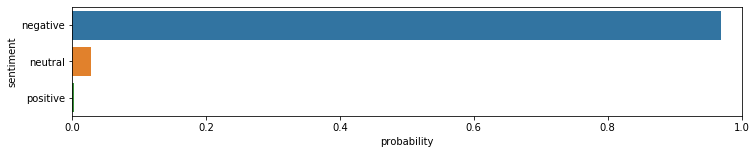

In [28]:
# text = "The coffee shop is quiet, probably as quiet as it can be while still being occupied. The staffs are friendly, and the coffee is delicious."
text = "The coffee shop is very noisy, average food, quite pricey, and bad management. I would not recommend this coffee shop to anyone."

predict(predictor, text)